In [1]:
import sys
import os
sys.path.append('/home/franzi/anzeigendaten/python_base/skillextraktion/fh_ma')
sys.path.append('/home/franzi/anzeigendaten/EnvPython')
import prepare_training_data
from labels import *
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

start = time.time()
x_train, y_train, x_test, y_test, test_afks, features = prepare_training_data.get_training_data(berufsgruppen=True, pos=True, word_features=True)
print('took: ',time.time()-start)

20861874
0
skipgram, punctuation_marks, stoppwords, multiword, lower_case, vector_dim True False False False False 100
init /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
loading existing w2v model from  /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
using data from  /home/franzi/Documents/data/data_bg_pos_wFeatures_4_vecDim100
loading data...
37823 37823 12053 12053 0 0
took:  5.3708412647247314


In [3]:
import numpy as np
for i,f in enumerate(features):
    features[i] = np.array(f)
pos_test, wf_test, bg_test, pos_train, wf_train, bg_train,  _, _, _ = features

print(wf_train[0]) # Abgeschlossene
print(pos_train[0]) # ADJA first
print(y_train[0])

[[0.         0.         0.         0.         1.         0.
  0.         0.         1.         0.         1.         0.00033559]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0. 0. 0. 0. 0. 0. 0. 1.]


In [5]:
from tensorflow.keras import *

In [6]:
wf_test = np.reshape(wf_test, (wf_test.shape[0], wf_test.shape[2]))
wf_train = np.reshape(wf_train, (wf_train.shape[0], wf_train.shape[2]))
pos_test = np.reshape(pos_test, (pos_test.shape[0], pos_test.shape[2]))
pos_train = np.reshape(pos_train, (pos_train.shape[0], pos_train.shape[2]))

In [7]:
# Build the model
print('Build model...')

vector_window_input = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
vw = layers.LSTM(256, return_sequences=True)(vector_window_input)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512, return_sequences=True)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.Dense(128, activation='relu')(vw)

wf_input = layers.Input(shape=(len(wf_train[0])))
f = layers.Dense(512, activation='relu')(wf_input)
f = layers.Dropout(0.5)(f)
f = layers.Dense(256, activation='relu')(f)

pos_input = layers.Input(shape=(len(pos_train[0])))
p = layers.Dense(512, activation='relu')(pos_input)
p = layers.Dropout(0.5)(p)
p = layers.Dense(256, activation='relu')(p)

bg_input = layers.Input(shape=(len(bg_train[0])))
b = layers.Dense(512, activation='relu')(bg_input)
b = layers.Dropout(0.5)(b)
b = layers.Dense(256, activation='relu')(b)

x = layers.concatenate([vw, f, p, b])
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

out = layers.Dense(units=len(labels), activation='softmax')(x)
all_model = models.Model(inputs=[vector_window_input, wf_input, pos_input, bg_input], outputs=[out])

all_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

all_model.evaluate(x=[x_test, wf_test, pos_test, bg_test], y=y_test)

batch_size=32
history = all_model.fit([x_train, wf_train, pos_train, bg_train], y_train, batch_size=batch_size, shuffle=True, epochs=5, validation_data=([x_test, wf_test, pos_test, bg_test], y_test))

Build model...


2020-08-20 09:25:12 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


12053/12053 [==============================] - 29s 2ms/sample - loss: 2.0729 - acc: 0.1538
Train on 37823 samples, validate on 12053 samples


2020-08-20 09:25:46 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
37823/37823 [==============================] - 230s 6ms/sample - loss: 0.7570 - acc: 0.7227 - val_loss: 0.6761 - val_acc: 0.7472
Epoch 2/5
37823/37823 [==============================] - 222s 6ms/sample - loss: 0.5917 - acc: 0.7840 - val_loss: 0.5201 - val_acc: 0.8170
Epoch 3/5
37823/37823 [==============================] - 213s 6ms/sample - loss: 0.4775 - acc: 0.8308 - val_loss: 0.4864 - val_acc: 0.8259
Epoch 4/5
37823/37823 [==============================] - 215s 6ms/sample - loss: 0.4356 - acc: 0.8464 - val_loss: 0.4495 - val_acc: 0.8431
Epoch 5/5
37823/37823 [==============================] - 238s 6ms/sample - loss: 0.4054 - acc: 0.8571 - val_loss: 0.4319 - val_acc: 0.8522


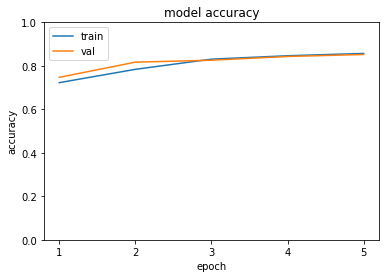

In [8]:
from matplotlib import pyplot as plt
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['acc'])
plt.plot(np.arange(1, len(history.history['acc'])+1), history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.xticks(np.arange(1, len(history.history['acc'])+1))
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [9]:
# predict test data
all_y_pred = all_model.predict([x_test, wf_test, pos_test, bg_test])
all_pred_label = prepare_training_data.one_hot_to_labels(all_y_pred)

In [ ]:
import numpy as np
# convert one hot to labels for test data
true_label = prepare_training_data.one_hot_to_labels(y_test)

In [11]:
# Build the model
print('Build model...')
lstm_model = Sequential()
lstm_model.add(layers.LSTM(256, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
lstm_model.add(layers.BatchNormalization())
lstm_model.add(layers.Dropout(0.5))
lstm_model.add(layers.LSTM(512, return_sequences=True))
lstm_model.add(layers.Dropout(0.5))
lstm_model.add(layers.BatchNormalization())
lstm_model.add(layers.LSTM(256))
lstm_model.add(layers.Dropout(0.5))
lstm_model.add(layers.Dense(256))
lstm_model.add(layers.Dense(units=len(labels)))
lstm_model.add(layers.Activation('softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

batch_size=32
history = lstm_model.fit(x_train, y_train, batch_size=batch_size, shuffle=True, epochs=5, validation_data=(x_test, y_test))

Build model...
Train on 37823 samples, validate on 12053 samples
Epoch 1/5
37823/37823 [==============================] - 166s 4ms/sample - loss: 0.8440 - acc: 0.6909 - val_loss: 0.6402 - val_acc: 0.7545
Epoch 2/5
37823/37823 [==============================] - 175s 5ms/sample - loss: 0.5404 - acc: 0.8088 - val_loss: 0.4553 - val_acc: 0.8366
Epoch 3/5
37823/37823 [==============================] - 178s 5ms/sample - loss: 0.4626 - acc: 0.8383 - val_loss: 0.4635 - val_acc: 0.8368
Epoch 4/5
37823/37823 [==============================] - 173s 5ms/sample - loss: 0.4241 - acc: 0.8533 - val_loss: 0.4348 - val_acc: 0.8519
Epoch 5/5
37823/37823 [==============================] - 160s 4ms/sample - loss: 0.3968 - acc: 0.8609 - val_loss: 0.4289 - val_acc: 0.8531


In [12]:
# predict test data
lstm_y_pred = lstm_model.predict([x_test])
lstm_pred_label = prepare_training_data.one_hot_to_labels(lstm_y_pred)

In [13]:
# Build the model
print('Build model...')

vector_window_input = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
vw = layers.LSTM(256, return_sequences=True)(vector_window_input)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512, return_sequences=True)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.LSTM(512)(vw)
vw = layers.Dropout(0.5)(vw)
vw = layers.BatchNormalization()(vw)
vw = layers.Dense(128, activation='relu')(vw)

pos_input = layers.Input(shape=(len(pos_train[0])))
p = layers.Dense(512, activation='relu')(pos_input)
p = layers.Dropout(0.5)(p)
p = layers.Dense(256, activation='relu')(p)

x = layers.concatenate([vw, p])
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

out = layers.Dense(units=len(labels), activation='softmax')(x)
pos_model = models.Model(inputs=[vector_window_input, pos_input], outputs=[out])

pos_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

pos_model.evaluate(x=[x_test, pos_test], y=y_test)

batch_size=32
history = pos_model.fit([x_train, pos_train], y_train, batch_size=batch_size, shuffle=True, epochs=5, validation_data=([x_test, pos_test], y_test))

Build model...
12053/12053 [==============================] - 29s 2ms/sample - loss: 2.0862 - acc: 0.0648
Train on 37823 samples, validate on 12053 samples
Epoch 1/5
37823/37823 [==============================] - 246s 7ms/sample - loss: 0.8500 - acc: 0.6847 - val_loss: 0.8201 - val_acc: 0.7104
Epoch 2/5
37823/37823 [==============================] - 235s 6ms/sample - loss: 0.6581 - acc: 0.7564 - val_loss: 0.5476 - val_acc: 0.8057
Epoch 3/5
37823/37823 [==============================] - 231s 6ms/sample - loss: 0.5057 - acc: 0.8236 - val_loss: 0.4713 - val_acc: 0.8380
Epoch 4/5
37823/37823 [==============================] - 232s 6ms/sample - loss: 0.4534 - acc: 0.8417 - val_loss: 0.4507 - val_acc: 0.8425
Epoch 5/5
37823/37823 [==============================] - 251s 7ms/sample - loss: 0.4184 - acc: 0.8556 - val_loss: 0.4418 - val_acc: 0.8445


In [14]:
# predict test data
pos_y_pred = pos_model.predict([x_test, pos_test])
pos_pred_label = prepare_training_data.one_hot_to_labels(pos_y_pred)

In [15]:
pred_label = []
for i in range(len(x_test)):
    curr_labels = [lstm_pred_label[i], all_pred_label[i], pos_pred_label[i]]
    if(curr_labels.count(lstm_pred_label[i] >= 2)): pred_label.append(lstm_pred_label[i])
    elif(curr_labels.count(all_pred_label[i] >= 2)): pred_label.append(all_pred_label[i])
    elif(curr_labels.count(pos_pred_label[i] >= 2)): pred_label.append(pos_pred_label[i])
    else: pred_label.append(pos_pred_label[i])

In [16]:
# Calc metrics for test data
import sklearn
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tabulate import tabulate
label_list = list(labels.keys())

headers = [l for l in label_list ]
headers = [' '] + headers

table=[['precision'] + list(precision_score(true_label, pred_label, average=None)), 
       ['recall']+list(recall_score(true_label, pred_label, average=None)), 
       ['f1']+ list(sklearn.metrics.f1_score(true_label, pred_label, average=None))]

print(tabulate(table, headers=headers, tablefmt='orgtbl'))
f1 = sklearn.metrics.f1_score(true_label, pred_label, average=None)
f1 = np.delete(f1, 4)
f1 = np.delete(f1, 6)
print('f1 average: ',sum(sklearn.metrics.f1_score(true_label, pred_label, average=None))/len(list(precision_score(true_label, pred_label, average=None))))
print('f1 average: ',sum(f1)/6)
print('Precision average: ',sum(precision_score(true_label, pred_label, average=None)/8))
print('recall average: ',sum(recall_score(true_label, pred_label, average=None)/8))
print('acc', sklearn.metrics.accuracy_score(true_label, pred_label))

|           |   Ausbildung |     Beruf |   allgemein |   berufsspez |   Sprache |   Technologie |   Softskill |   noSkill |
|-----------+--------------+-----------+-------------+--------------+-----------+---------------+-------------+-----------|
| precision |     0.718056 | 1         |    0.566563 |     0.587336 |  0.971429 |      0.799065 |    0.689655 |  0.947745 |
| recall    |     0.936594 | 0.015625  |    0.256662 |     0.754206 |  0.923077 |      0.882581 |    0.928505 |  0.889988 |
| f1        |     0.812893 | 0.0307692 |    0.353282 |     0.660393 |  0.946636 |      0.838749 |    0.791452 |  0.917959 |
f1 average:  0.6690166784539674
f1 average:  0.581256418849967
Precision average:  0.7849812377327221
recall average:  0.6984047006489518
acc 0.8415332282419314


In [17]:
lstm_prob = lstm_model.predict_proba([x_test])
pos_prob = pos_model.predict([x_test, pos_test])
all_prob = all_model.predict([x_test, wf_test, pos_test, bg_test])

In [18]:
pred_label2 = []
probabilities = []
for i in range(len(x_test)):
    probs = [0] * len(labels)
    items = [lstm_prob[i], all_prob[i], pos_prob[i]]
    stats = {}
    for net in range(len(items)):
        for index in range(len(items[net])):
            probs[index] += items[net][index]
    pred_label2.append(probs.index(max(probs)))

In [19]:
# Calc metrics for test data
import sklearn
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tabulate import tabulate
label_list = list(labels.keys())

headers = [l for l in label_list ]
headers = [' '] + headers

table=[['precision'] + list(precision_score(true_label, pred_label2, average=None)), 
       ['recall']+list(recall_score(true_label, pred_label2, average=None)), 
       ['f1']+ list(sklearn.metrics.f1_score(true_label, pred_label2, average=None))]

print(tabulate(table, headers=headers, tablefmt='orgtbl'))
f1 = sklearn.metrics.f1_score(true_label, pred_label2, average=None)
f1 = np.delete(f1, 4)
f1 = np.delete(f1, 6)
print('f1 average: ',sum(sklearn.metrics.f1_score(true_label, pred_label2, average=None))/len(list(precision_score(true_label, pred_label2, average=None))))
print('f1 average: ',sum(f1)/6)
print('Precision average: ',sum(precision_score(true_label, pred_label2, average=None)/8))
print('recall average: ',sum(recall_score(true_label, pred_label2, average=None)/8))
print('acc', sklearn.metrics.accuracy_score(true_label, pred_label2))

|           |   Ausbildung |    Beruf |   allgemein |   berufsspez |   Sprache |   Technologie |   Softskill |   noSkill |
|-----------+--------------+----------+-------------+--------------+-----------+---------------+-------------+-----------|
| precision |     0.821192 | 0.52381  |    0.618557 |     0.661398 |  0.976852 |      0.819809 |     0.75416 |  0.940231 |
| recall    |     0.898551 | 0.171875 |    0.336606 |     0.742991 |  0.954751 |      0.886452 |     0.92572 |  0.925472 |
| f1        |     0.858131 | 0.258824 |    0.435967 |     0.699824 |  0.965675 |      0.851829 |     0.83118 |  0.932793 |
f1 average:  0.7292778162649272
f1 average:  0.6559591353121371
Precision average:  0.7645009667157844
recall average:  0.7303020223375116
acc 0.8672529660665395


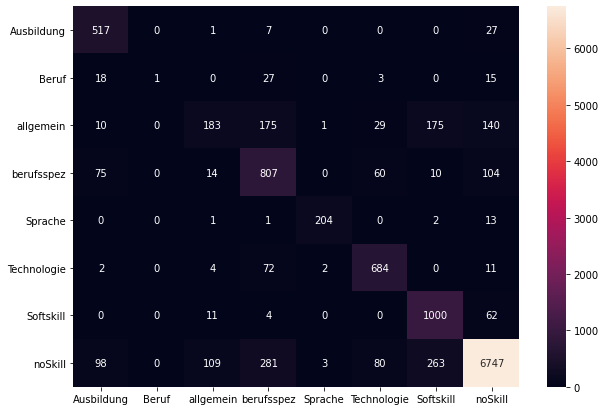

In [20]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')

In [21]:
# clean noSkill for evaluation
clean_y_pred = []
clean_y_test = []
true_noSkills = 0
clean_x_test = []
afks = []

for i in range(len(y_test)):
    if(true_label[i] != 7 or pred_label[i] != 7):
        clean_x_test.append(x_test[i])
        clean_y_pred.append(pred_label[i])
        clean_y_test.append(true_label[i])
        afks.append(test_afks[i])
    else:
        true_noSkills += 1
pred_label = clean_y_pred
true_label = clean_y_test
print('correctly labeled noSkills: ', true_noSkills)

correctly labeled noSkills:  6747


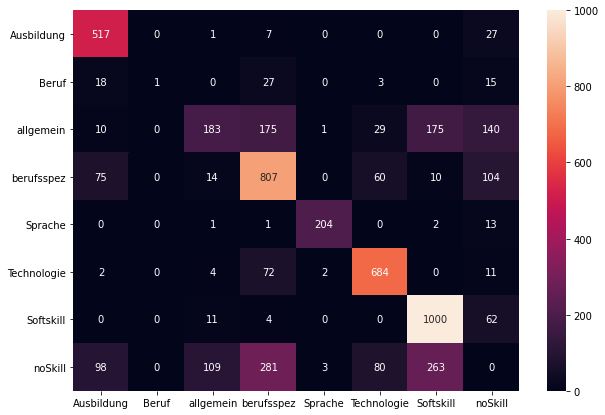

In [22]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labels,columns = labels)
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')

In [23]:
from word2vec import W2V#get_closest_word_to_vec_matrix
correct = []
false = []

clean_x_test, pred_label, true_label, afks = shuffle(clean_x_test, pred_label, true_label, afks,random_state=0)
skill_index = int(len(clean_x_test[0])/2)
label_list = list(labels.keys())


headers = [['|']+[l] for l in label_list ]
headers = sum(headers, [])
headers.append('|')

wvs = []
for i in range(len(clean_x_test)):
    wvs.append(clean_x_test[i][skill_index])

w2v = W2V(skipgram=True, punctuation_marks=False, stoppwords=False, multiword=False, lower_case=False, vector_dim=100)
predictions = [[],[],[],[],[],[],[], []]
for i in range(len(clean_x_test)):
    word = w2v.get_closest_word_to_vec(wvs[i])[0][0]
    label = str(true_label[i])
    predictions[pred_label[i]].append(word + '('+label+')')

table = []
# format
i = 0
while(i < len(predictions[0]) or i < len(predictions[1]) or i < len(predictions[2]) or i < len(predictions[3]) or i < len(predictions[4]) or i < len(predictions[5] or i < len(predictions[6]))):
    row = ['|']
    for x in predictions:
        if(len(x) > i and len(x[i]) <  25): 
            row.append(x[i])
            row.append('|')
        else:
            row.append('')
            row.append('|')
            
    table.append(row)
    i+=1    

print(tabulate(table, headers=headers))

skipgram, punctuation_marks, stoppwords, multiword, lower_case, vector_dim True False False False False 100
init /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
loading existing w2v model from  /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
|    Ausbildung                |    Beruf              |    allgemein                 |    berufsspez                |    Sprache                   |    Technologie               |    Softskill                 |    noSkill                   |
---  ------------------------  ---  -----------------  ---  ------------------------  ---  ------------------------  ---  ------------------------  ---  ------------------------  ---  ------------------------  ---  ------------------------  ---
|    Wirtschaftsinformatik(0)  |    Serviceberater(1)  |    körperliche(7)            |    Webserver-Bereich(3)      |    Englisch(4)               |    ERP-Systemen(3)           |    speditive(2)              |    Sam